In [ ]:
import glob
import os
import random
from datetime import date, datetime
from importlib import reload

import geopandas as gpd
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
import sigfig
from scipy import stats
from scipy.ndimage import distance_transform_edt
from scipy.stats import linregress

from project_config import get_config
from src import classification, pipeline, pixel_regression

cfg = get_config()

## Generate Pixel Regressions (linear trend for every pixel over the study period)

In [73]:
## Roughly 1hr to run
indexes = cfg.composites.get_all()
pixreg_output_folder = cfg.paths.pixel_regression
index_scaling=10*365

run_pixreg = False
if run_pixreg:
    for index_name in indexes:
        if index_name != 'RGB':
            plot_index_path = None
            classes_for_reg = [1]
            
            # Run pixel regression
            try:
                trend_stack, intercept_stack, dist_plot = pixel_regression.pixel_regression(
                    index_name=index_name, 
                    plot_index_path=plot_index_path,
                    classes_for_reg=[0,1,2],
                    index_scaling=index_scaling,
                    plot_index_toggle=False
                )
                
                # Save all three outputs together as compressed npz
                output_path = os.path.join(pixreg_output_folder, f"{index_name}_pixelreg.npz")
                np.savez_compressed(output_path, 
                                trend=trend_stack, 
                                intercept=intercept_stack, 
                                dist_plot=dist_plot)
            except:
                print(f'something went wrong with index {index_name}')
            
            print(f"Saved {index_name} pixel regression outputs to {output_path}")

## Plot Trend Maps

In [177]:
def load_pixreg_for_index(index_name, pixreg_output_folder=cfg.paths.pixel_regression):
    data = np.load(f'{pixreg_output_folder}/{index_name}_pixelreg.npz')
    return data['trend'], data['intercept'], data['dist_plot']

def load_pix_reg_for_all_indexes(indexes=indexes):
    trends = {}
    for index in indexes:
        trends[index], _, _ = load_pixreg_for_index(index)
    return trends

trends = load_pix_reg_for_all_indexes([i for i in indexes if i != 'RGB'])

In [219]:
reload(pixel_regression)
final_state_all, final_state_plot = pixel_regression.get_final_state(classes_for_reg = [-1,0,1,2])
_, final_state_plot_no_water = pixel_regression.get_final_state(classes_for_reg = [1])
# Convert array to GeoDataFrame
classified_gdf = classification.array_to_polygons(final_state_all)

# Define color mapping
color_map = {
    -1: 'blue', # ocean
    1: 'green', # jungle
    2: 'orange', # cleared land
    254: 'gray' # nodata
}

values_to_plot = [-1, 254]

figsize = (10,10)

def plot_trend_map_for_index(index, final_state=final_state_plot, borders_gdf=classified_gdf):
    trend, _, _ = load_pixreg_for_index(index)
    ax = pixel_regression.plot_index(trend, final_state, index, borders=borders_gdf, scaling=index_scaling, figsize=figsize, title=f'b) {index} Decadal Trend Map')
    if borders_gdf:
        pixel_regression.plot_polygon_borders(borders_gdf, ax, values_to_plot, color_map, linewidth=1)

    # Show the combined plot
    plt.show()
    return trend

c:\Users\anson\Documents\University\2\GEOM90005 Remote Sensing\Project\wedabaywatch\src\pixel_regression.py:271: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plot_dist = False,


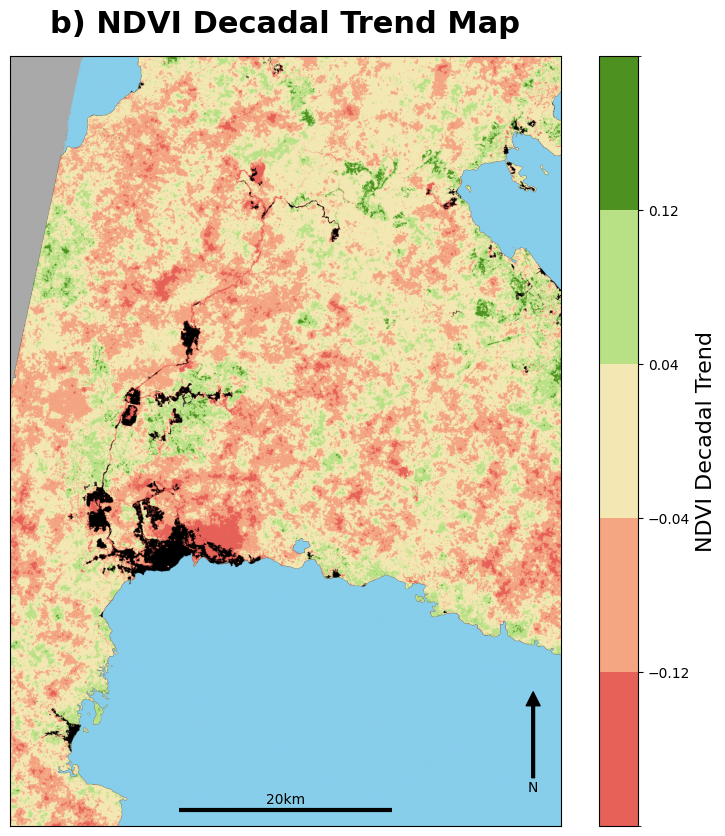

array([[           nan,            nan,            nan, ...,
         3.6210138e-06,  4.1767926e-06,  2.6760522e-06],
       [           nan,            nan,            nan, ...,
        -8.5115312e-07, -2.4221040e-07, -3.1647294e-06],
       [           nan,            nan,            nan, ...,
        -1.4728524e-06, -1.7573651e-06, -2.1456531e-06],
       ...,
       [ 1.2481891e-05,  1.1058230e-05,  4.8656625e-06, ...,
        -9.0377516e-06, -7.1532595e-06, -6.7101253e-05],
       [ 8.4067924e-06,  7.1129161e-06,  6.8499785e-06, ...,
        -2.0841137e-06,  9.5060514e-06, -5.9788923e-05],
       [ 3.7932961e-07, -3.0439409e-07,  4.4001085e-06, ...,
         1.0658807e-05,  3.5444732e-06, -2.8604394e-05]],
      shape=(2412, 1725), dtype=float32)

In [226]:
reload(pixel_regression)
plot_trend_map_for_index('NDVI', final_state=final_state_plot_no_water, borders_gdf=None)

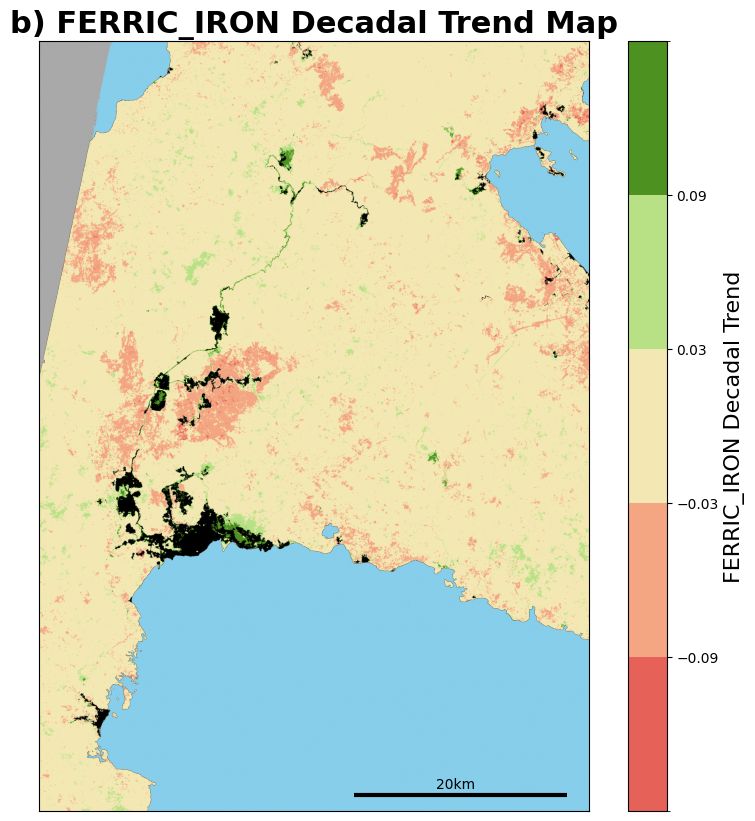

array([[           nan,            nan,            nan, ...,
        -2.1429109e-06, -8.5103335e-07, -1.7934104e-06],
       [           nan,            nan,            nan, ...,
        -1.6906299e-06, -2.1530891e-06, -1.0841596e-06],
       [           nan,            nan,            nan, ...,
        -1.9388679e-06, -1.5290379e-06, -2.4182623e-06],
       ...,
       [-5.1827560e-06, -5.7511857e-06, -1.9007343e-06, ...,
         2.3353521e-05,  4.0949773e-05,  7.1631759e-05],
       [-4.1075464e-06, -3.2904857e-06, -2.8950190e-06, ...,
         2.1320180e-05,  6.2874838e-06,  3.1386244e-05],
       [-2.0531870e-06, -1.9820491e-06, -4.7433791e-06, ...,
         2.8818831e-05,  1.6962740e-05,  1.5994414e-05]],
      shape=(2412, 1725), dtype=float32)

In [216]:
plot_trend_map_for_index("FERRIC_IRON", final_state=final_state_plot_no_water, borders_gdf=None)

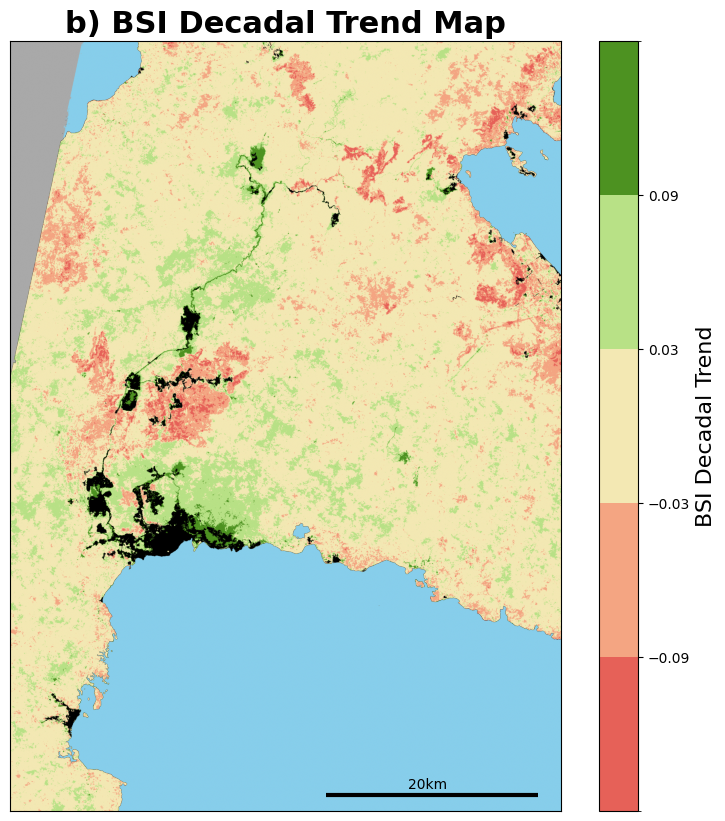

array([[           nan,            nan,            nan, ...,
        -5.8869109e-06, -7.3170663e-06, -4.5675888e-06],
       [           nan,            nan,            nan, ...,
        -2.4884177e-06, -3.4308323e-06, -2.7998072e-07],
       [           nan,            nan,            nan, ...,
        -2.9151799e-06, -2.8524578e-06, -1.8885964e-06],
       ...,
       [-8.0762884e-06, -7.8292624e-06, -4.7449903e-06, ...,
        -8.1221442e-05, -9.6020398e-05, -1.8754201e-04],
       [-7.8350186e-06, -7.9203201e-06, -6.1031928e-06, ...,
        -5.7704121e-05, -1.2415973e-05, -1.5780980e-04],
       [-4.2012052e-06, -5.6154277e-06, -3.3685565e-06, ...,
        -4.2325886e-05, -5.6669560e-05, -1.1359942e-04]],
      shape=(2412, 1725), dtype=float32)

In [217]:
plot_trend_map_for_index("BSI", final_state=final_state_plot_no_water, borders_gdf=None)

### Calculate relationship between NDVI and distance to a mine

In [143]:
final_state = final_state_all
final_state_blobbed = classification.clean_small_regions(final_state, min_size= 1000)

final_state_no_cleared = np.where(final_state_blobbed == 2,1, final_state_blobbed)

final_state_blobbed[1700:,] = final_state_no_cleared[1700:,]

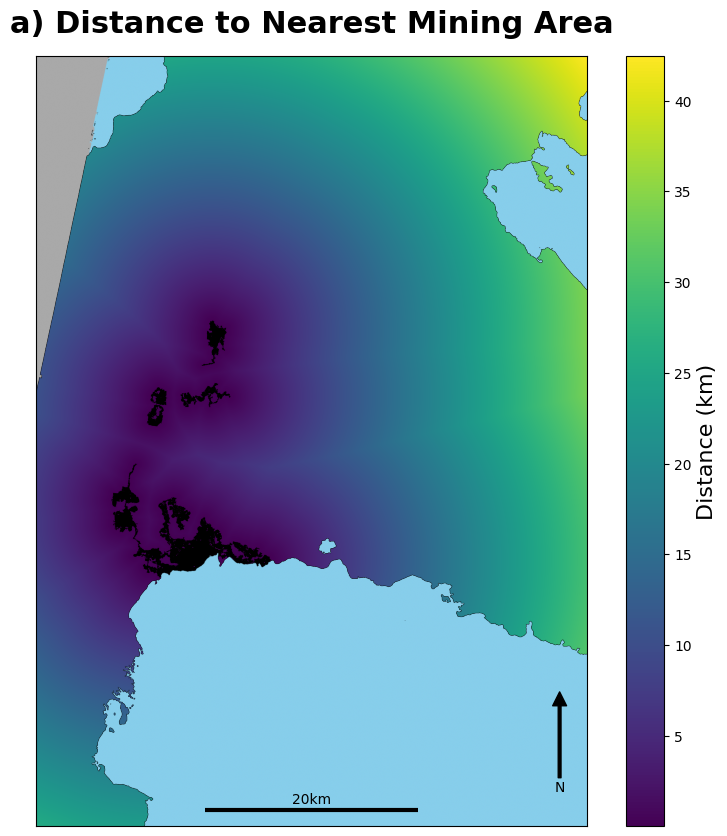

In [227]:
dist_blobbed = pixel_regression.calculate_distance(final_state_blobbed)

# --- Prepare data ---
final_state_ocean_na = np.where(final_state_blobbed == 22, np.nan, final_state_blobbed)

classes = {
    3: ("Cloud", "lightgrey"),
    1: ("Jungle", "black"),
    2: ("Cleared Land", "black"),
    0: ("Ocean", "skyblue"),
    254: ("No data", "darkgrey"),
}

vals, info = zip(*sorted(classes.items()))
names, cols = zip(*info)

class_cmap = mcolors.ListedColormap(cols)
class_norm = mcolors.BoundaryNorm([v - 0.5 for v in vals] + [vals[-1] + 0.5], len(vals))

remaining_class_values = np.unique(final_state_ocean_na)
class_labels = [classes[c][0] for c in remaining_class_values[remaining_class_values >= 0]]

# --- Plot ---
fig, ax = plt.subplots(figsize=figsize)

# Class image
ax.imshow(final_state_ocean_na, cmap=class_cmap, norm=class_norm)

# Distance overlay
im_dist = ax.imshow(dist_blobbed*30/1000, cmap='viridis')  # pixels -> km
# im_dist = ax.imshow(dist_blobbed*30/1000, cmap='viridis')  # pixels -> km
cbar = fig.colorbar(im_dist, ax=ax)
cbar.set_label(label='Distance (km)', fontsize=16)

ax.set_title('a) Distance to Nearest Mining Area', fontsize=22, fontweight='bold', pad=17)
ax.set_xticks([])  # turn off x-axis
ax.set_yticks([])  # turn off y-axis

# Scale bar
pixel_size = 30  # meters per pixel
scalebar_length_m = 20000
scalebar_length_px = scalebar_length_m / pixel_size

# Your custom add_scalebar function (assumes it’s defined somewhere)
pixel_regression.add_scalebar(ax, scalebar_length_px, label = "20km")
pipeline.PlotUtils.add_north_arrow()

plt.savefig('output/plots/distance_heatmap.svg')


### Trend of Trends

In [196]:
def final_trend_pixel_plot(index, trend, scale=365*10):
    trend_stack_scaled = trend * scale
    # Flattened arrays
    x = dist_blobbed.flatten()*30/1000
    y = trend_stack_scaled.flatten()

    plt.figure(figsize=(8.4, 7))
    plt.scatter(x,y, alpha = 1/255,s=1/3)

    # Remove NaNs
    mask = ~np.isnan(x) & ~np.isnan(y)
    x = x[mask]
    y = y[mask]

    # Linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    r_squared = r_value**2

    print(f"Slope: {slope}")
    print(f"Intercept: {intercept}")
    print(f"R-squared: {r_squared}")
    print(f"P-value: {p_value}")

    reg_line_max = x.max()

    plt.plot([0,reg_line_max],[intercept,intercept+slope*reg_line_max], c = 'salmon', label = "Linear Regression")
    # --- Custom legend-style box ---
    ax = plt.gca()

    # Text content
    text = (f"Linear Regression\n"
            f"Slope = {slope:.3e}\n"
            f"R² = {r_squared:.3f}\n"
            f"P-value = {p_value:.3e}")

    # Add text first (invisible for sizing)
    t = ax.text(0.71, 0.974, text,
            transform=ax.transAxes,
            fontsize=12,
            va='top', ha='left',
            color='black',
            linespacing=1.3,
            bbox=dict(facecolor='white', edgecolor='salmon',
                    boxstyle='round,pad=0.4', lw=1.2, alpha=0.8))

    plt.title(f"{index} Trend and Distance from Mining Area", fontsize=20, fontweight='bold')
    plt.xlabel("Distance from Mining Area (km)", fontsize=14)
    plt.ylabel(f"{index} Decadal Trend", fontsize=14)
    plt.ylim((-0.5,0.5))
    #
    # plt.savefig("output/plots/distance_trendline.jpg")

Slope: 0.0010957544379867066
Intercept: -0.03926296852914195
R-squared: 0.030838417000119966
P-value: 0.0


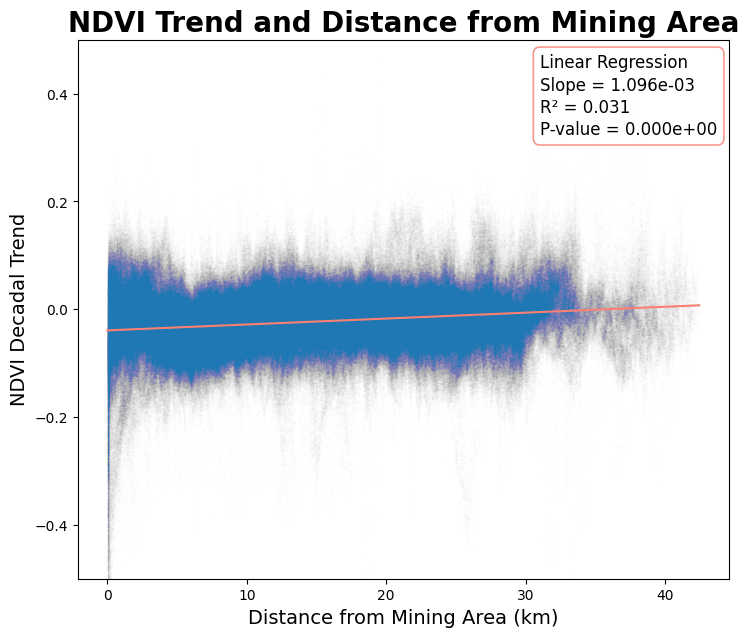

In [197]:
index = 'NDVI'
final_trend_pixel_plot(index, trends[index], index_scaling)

Slope: -0.0009049811533982417
Intercept: 0.017306665846652212
R-squared: 0.06723172762259291
P-value: 0.0


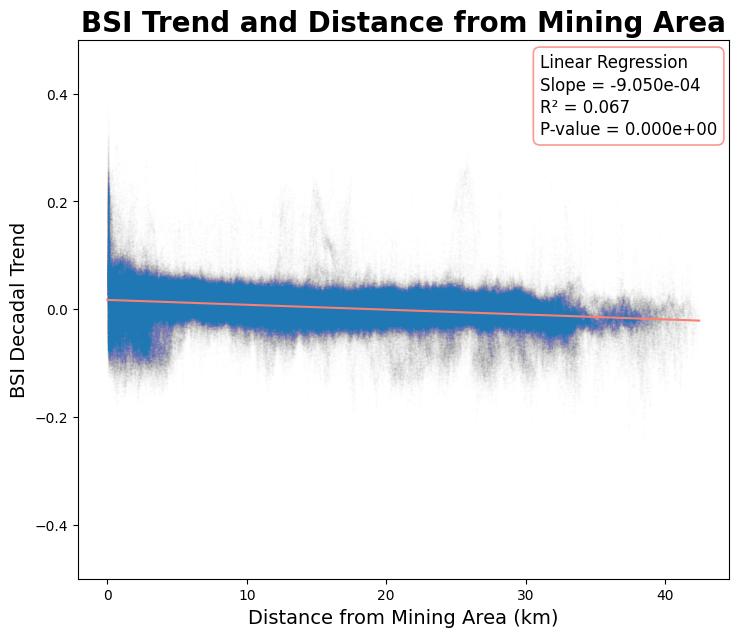

In [210]:
index = 'BSI'
final_trend_pixel_plot(index, trends[index], index_scaling)

In [ ]:
index = 'BSI'
final_trend_pixel_plot(index, trends[index], index_scaling)

Slope: 0.0003486133891383495
Intercept: 0.2887277586131237
R-squared: 0.0006893873593069683
P-value: 0.0


(-0.5, 0.5)

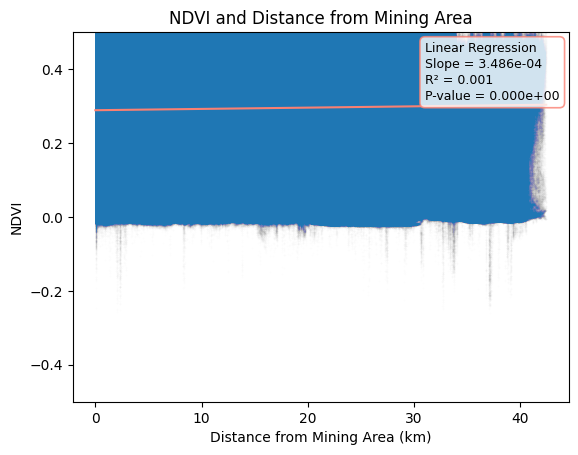

In [165]:
class_stack, filenames = pixel_regression.get_class_stack()

index_stack = pixel_regression.get_index_stack(class_stack.shape, filenames)



# Flattened arrays
x = dist_blobbed.flatten()*30/1000
x = np.tile(x, 63)
y = index_stack.flatten()

plt.scatter(x,y, alpha = 1/255,s=1/3)

# Remove NaNs
mask = ~np.isnan(x) & ~np.isnan(y)
x = x[mask]
y = y[mask]

# Linear regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)

r_squared = r_value**2

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared: {r_squared}")
print(f"P-value: {p_value}")

reg_line_max = x.max()

plt.plot([0,reg_line_max],[intercept,intercept+slope*reg_line_max], c = 'salmon', label = "Linear Regression")
# --- Custom legend-style box ---
ax = plt.gca()

# Text content
text = (f"Linear Regression\n"
        f"Slope = {slope:.3e}\n"
        f"R² = {r_squared:.3f}\n"
        f"P-value = {p_value:.3e}")

# Add text first (invisible for sizing)
t = ax.text(0.71, 0.974, text,
            transform=ax.transAxes,
            fontsize=9,
            va='top', ha='left',
            color='black',
            linespacing=1.3,
            bbox=dict(facecolor='white', edgecolor='salmon',
                      boxstyle='round,pad=0.4', lw=1.2, alpha=0.8))



plt.title("NDVI and Distance from Mining Area")
plt.xlabel("Distance from Mining Area (km)")
plt.ylabel("NDVI")
plt.ylim((-0.5,0.5))
#
#plt.savefig("output/plots/distance_trendline_NDVIonly.jpg")

### Plot individual paths

4% complete
8% complete
12% complete
16% complete
20% complete
24% complete
28% complete
33% complete
37% complete
41% complete
45% complete
49% complete
53% complete
58% complete
62% complete
66% complete
70% complete
74% complete
78% complete
82% complete
87% complete
91% complete
95% complete
99% complete


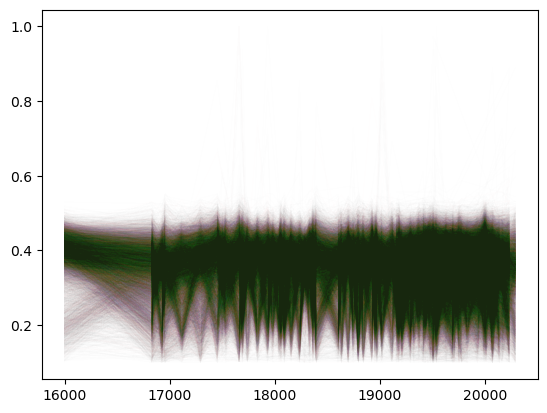

In [23]:
H, W = index_stack.shape[1:]
min_datapoints_for_reg = 5

for y in range(H):
    for x in range(W):
        s = class_stack[:,y,x]
        ndvi_s = index_stack[:,y,x]
        s_filter = ((s == 1) & ~np.isnan(ndvi_s) & (ndvi_s > 0.1))
        if s_filter.sum() < min_datapoints_for_reg:
            continue
        # only print 1% of pixels
        if random.random() > 0.01:
            continue
        plt.plot(dates_int[s_filter],ndvi_s[s_filter], linewidth = 1, alpha = 1/255)
    if y % 100 == 99:
        comp_perc = int(100*y/H)
        print(f"{comp_perc}% complete")

### Explore seasonality

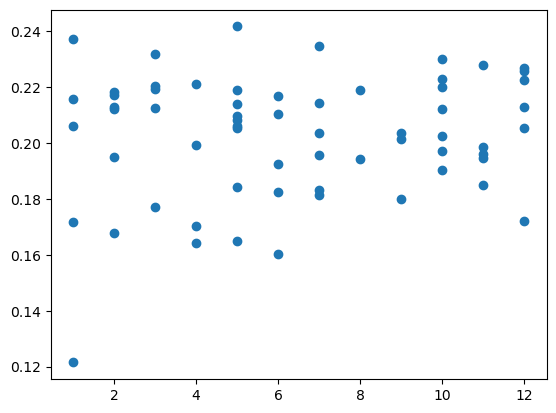

In [149]:

y = np.nanmean(index_stack, axis = (1,2))
x = [dt.month for dt in dates_dt]

plt.scatter(x,y)

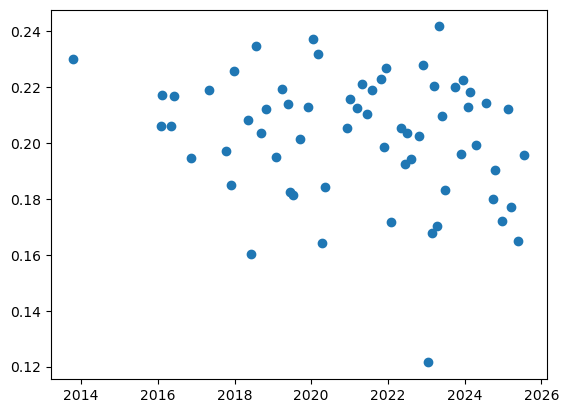

In [150]:
y = np.nanmean(index_stack, axis = (1,2))
x = dates_dt

plt.scatter(x,y)

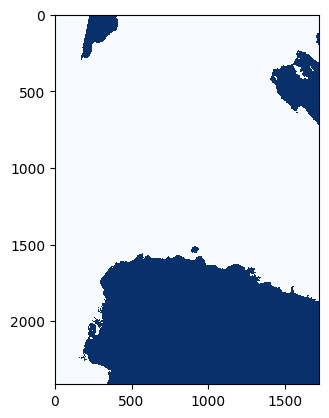

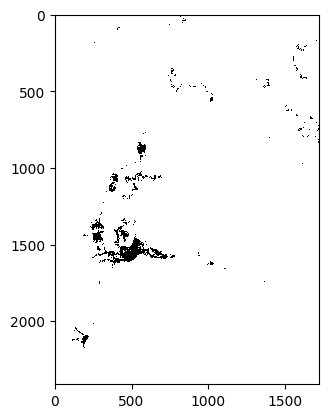

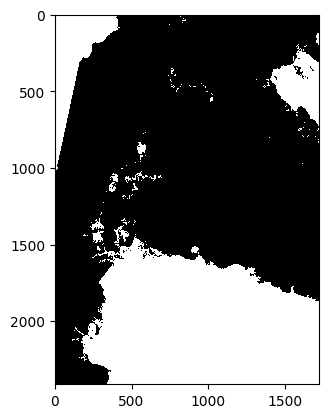

In [240]:
pth = cfg.paths.classified + '/jungle_to_mine_change.tif'
fs, fs2 = pixel_regression.get_final_state()


plt.imshow(fs == -1, cmap='Blues', interpolation='none')
plt.show()
plt.imshow((fs == 2), cmap='Greys', interpolation='none')
plt.show()
plt.imshow((fs == 1), cmap='Greys', interpolation='none')
plt.show()
